In [19]:
# project 2, Group 7

In [20]:
# task 1

In [21]:
class OptimizationProblem:
    def __init__(self, f, grad=None):
        self.f = f
        self.grad = grad

    def evaluate(self, x):
        return float(self.f(x))

    def gradient(self, x):
        if self.grad is None:
            raise NotImplementedError("No gradient provided.")
        return np.array(self.grad(x), dtype=float)

In [22]:
# task 2: general opitimization class

In [23]:
class OptimizationMethod:
    def __init__(self, problem, tol=1e-6, max_iter=100):
        self.problem = problem
        self.tol = tol
        self.max_iter = max_iter
        self.history = []

    def compute_direction(self, x):
        # need implemention
        raise NotImplementedError

    def line_search(self, x, s, g):
        alpha = 1.0  # will be changed in the subsequet tasks 
        return alpha

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        self.history.append(x.copy()) # record the history for task5
        for _ in range(self.max_iter):
            g = self.problem.gradient(x)
            if np.linalg.norm(g) < self.tol:
                break
            s = self.compute_direction(x, g)
            alpha = self.line_search(x, s, g)
            x = x + alpha * s
            self.history.append(x.copy()) # record the history for task5
        return x


In [24]:
#task 3
import numpy as np

def fd_hessian(f, x, eps=1e-6):
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n); ej[j] = 1.0
            if i == j:
                H[i, i] = (f(x + eps * ei) - 2 * fx + f(x - eps * ei)) / eps**2
            else:
                fpp = f(x + eps * ei + eps * ej)
                fpm = f(x + eps * ei - eps * ej)
                fmp = f(x - eps * ei + eps * ej)
                fmm = f(x - eps * ei - eps * ej)
                H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4 * eps**2)
    return 0.5 * (H + H.T)

# clarify for the task3
class NewtonMethod(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(H, g)

In [25]:
# task 4
from scipy.optimize import minimize_scalar

class NewtonMethodExactLineSearch(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(H, g)

    def line_search(self, x, s, g):
        phi = lambda alpha: self.problem.evaluate(x + alpha * s)
        res = minimize_scalar(phi, bounds=(0, 1), method='bounded')
        return res.x

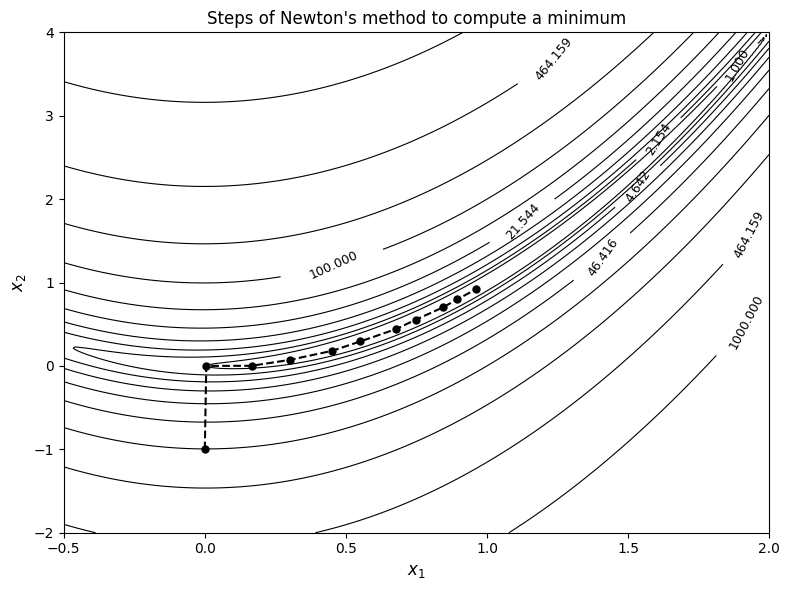

In [ ]:
#task 5
import matplotlib.pyplot as plt
import numpy as np

# Define Rosenbrock function and its gradient
def rosenbrock_f(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_grad(x):
    df_dx0 = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    df_dx1 = 200 * (x[1] - x[0]**2)
    return np.array([df_dx0, df_dx1])

problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
optimizer = NewtonMethodExactLineSearch(problem, max_iter=10)
x0 = np.array([0.0, -1.0])
xmin = optimizer.solve(x0)
trajectory = np.vstack(optimizer.history)

x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 4, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = 100 * (Y - X**2)**2 + (1 - X)**2

plt.figure(figsize=(8, 6))

levels = np.logspace(0, 3, 10) # from 1 to 1000
CS = plt.contour(X, Y, Z, levels=levels, colors='black', linewidths=0.8)
plt.clabel(CS, inline=True, fontsize=9, fmt="%.3f")


plt.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=1.5)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ko', markersize=5)

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title("Steps of Newton's method to compute a minimum", fontsize=12)
plt.xlim([-0.5, 2.0])
plt.ylim([-2.0, 4.0])
plt.grid(False)
plt.tight_layout()
plt.show()


Our figure shows Newton’s method with exact line search. Compared to Powell’s method in Fig. 1 (right), Newton’s method takes smaller, more curved steps that follow the Rosenbrock valley more precisely. This is due to its use of second-order information. Both visualizations use black dots and dashed lines to show the optimization path, making the comparison clear and consistent.

In [27]:
# Task 6 
def line_search_goldstein_wolfe(problem, x, p, grad_x,
                                rho=0.01, sigma=0.1,
                                tau1=9.0, tau2=0.1, tau3=0.5,
                                alpha1=1.0, fbar=-np.inf, max_iter=50):

    phi0 = problem.evaluate(x)
    dphi0 = float(np.dot(grad_x, p))

    def phi(a): return problem.evaluate(x + a * p)
    def dphi(a): return float(np.dot(problem.gradient(x + a * p), p))

    # === Bracketing phase ===
    alpha_prev = 0.0
    alpha_i = alpha1
    mu = (fbar - phi0) / (rho * dphi0)

    for i in range(1, max_iter + 1):
        f_alpha_i = phi(alpha_i)

        if f_alpha_i <= fbar:
            return alpha_i

        if (f_alpha_i > phi0 + rho * alpha_i * dphi0) or (i > 1 and f_alpha_i >= phi(alpha_prev)):
            ai, bi = alpha_prev, alpha_i
            break

        fprime_alpha_i = dphi(alpha_i)

        if abs(fprime_alpha_i) <= -sigma * dphi0:
            return alpha_i

        if fprime_alpha_i >= 0:
            ai, bi = alpha_i, alpha_prev
            break

        if mu <= 2 * alpha_i - alpha_prev:
            alpha_next = mu
        else:
            alpha_next = 0.5 * ((2 * alpha_i - alpha_prev) + min(mu, alpha_i + tau1 * (alpha_i - alpha_prev)))

        alpha_prev, alpha_i = alpha_i, alpha_next
    else:
        return alpha_i

    if "ai" not in locals() or "bi" not in locals():
        return alpha_i
    
    # === Sectioning phase ===
    aj, bj = ai, bi
    for j in range(max_iter):
        # choose αj ∈ [aj+τ2(bj−aj), bj−τ3(bj−aj)]
        alpha_j = 0.5 * ((1 - tau2 - tau3) * aj + (tau2 + tau3) * bj)

        f_alpha_j = phi(alpha_j)

        if (f_alpha_j > phi0 + rho * alpha_j * dphi0) or (f_alpha_j >= phi(aj)):
            aj, bj = aj, alpha_j
        else:
            fprime_alpha_j = dphi(alpha_j)
            if abs(fprime_alpha_j) <= -sigma * dphi0:
                return alpha_j
            aj = alpha_j
            if (bj - aj) * fprime_alpha_j >= 0:
                bj = aj
            else:
                bj = bj
    return alpha_j


In [28]:
# Task 7
x0 = np.array([-1.2, 1.0])
g0 = problem.gradient(x0)
p0 = -g0  # search direction

rho, sigma = 0.01, 0.1
tau1, tau2, tau3 = 9.0, 0.1, 0.5

for alpha1 in (0.1, 1.0):  # Table 2.6.1
    alpha = line_search_goldstein_wolfe(
        problem, x0, p0, g0,
        rho=rho, sigma=sigma,
        tau1=tau1, tau2=tau2, tau3=tau3,
        alpha1=alpha1
    )
    x1 = x0 + alpha * p0
    f0 = problem.evaluate(x0)
    f1 = problem.evaluate(x1)

    # Check Wolfe–Powell conditions
    armijo_ok = (f1 <= f0 + rho * alpha * np.dot(g0, p0))
    wolfe_ok = (abs(np.dot(problem.gradient(x1), p0)) <= -sigma * np.dot(g0, p0))

    print(f"alpha1={alpha1} -> alpha={alpha}")
    print(f"f(x0)={f0}, f(x1)={f1}")
    print(f"Armijo: {armijo_ok}, Wolfe: {wolfe_ok}\n")


alpha1=0.1 -> alpha=0.0008099999999999998
f(x0)=24.199999999999996, f(x1)=4.141734836674481
Armijo: True, Wolfe: True

alpha1=1.0 -> alpha=0.0007289999999999999
f(x0)=24.199999999999996, f(x1)=4.227608042702007
Armijo: True, Wolfe: True



In [29]:
# Task 8 
class NewtonMethodInexactLineSearch(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)   # 有限差分 Hessian
        return -np.linalg.solve(H, g)

    def line_search(self, x, s, g):
        return line_search_goldstein_wolfe(
            self.problem, x, s, g,
            rho=0.01, sigma=0.1,
            tau1=9.0, tau2=0.1, tau3=0.5,
            alpha1=1.0
        )


In [30]:
# Task 9

class QuasiNewtonMethod(OptimizationMethod):
    def __init__(self, problem, tol=1e-6, max_iter=100):
        super().__init__(problem, tol, max_iter)

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        g = self.problem.gradient(x)
        n = len(x)

        # Start with identity as inverse Hessian approx
        H = np.eye(n)

        self.history.append(x.copy())

        for _ in range(self.max_iter):
            # Convergence check
            if np.linalg.norm(g) < self.tol:
                break

            # Search direction
            s = -H.dot(g)

            # Inexact line search (Wolfe)
            alpha = line_search_wolfe(self.problem, x, s, g)
            x_new = x + alpha * s
            g_new = self.problem.gradient(x_new)

            # Update matrices
            y = g_new - g
            s = x_new - x
            H = self.update(H, s, y, g, g_new)

            # Move to next iterate
            x, g = x_new, g_new
            self.history.append(x.copy())

        return x

    def update(self, H, s, y, g, g_new):
        raise NotImplementedError


In [31]:
# Task 9.1 good Broyden
class GoodBroyden(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        # Compute G = H^{-1} implicitly by Sherman-Morrison
        Hy = H.dot(y)
        u = s - Hy
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        # Sherman–Morrison
        H_new = H + np.outer(u, u) / denom
        return H_new


In [32]:
# Task 9.2 Bad Broyden
class BadBroyden(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        u = s - H.dot(y)
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        H_new = H + np.outer(u, u) / denom
        return H_new


In [33]:
# Task 9.3 Symmetric Broyden
class SymmetricBroyden(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        u = s - H.dot(y)
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        upd = np.outer(u, u) / denom
        H_new = H + 0.5 * (upd + upd.T)   # symmetrize
        return H_new


In [34]:
# Task 9.4 DFP
class DFP(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        sy = s @ y
        if abs(sy) < 1e-12:
            return H
        Hy = H.dot(y)
        H_new = H + np.outer(s, s) / sy - np.outer(Hy, Hy) / (y @ Hy)
        return H_new



In [35]:
# Task 9.5 BFGS
class BFGS(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        rho = 1.0 / (y @ s)
        I = np.eye(len(s))
        V = I - rho * np.outer(s, y)
        H_new = V @ H @ V.T + rho * np.outer(s, s)
        return H_new


In [36]:
# Task 9 
# Example usage
problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
x0 = np.array([-1.2, 1.0])

optimizer = BFGS(problem, max_iter=50)
xmin = optimizer.solve(x0)

print("Found minimum:", xmin)


NameError: name 'line_search_wolfe' is not defined

In [ ]:
# Task 10 (minimal): run BFGS once on Chebyquad (n=8)
import numpy as np
from chebyquad_problem import chebyquad, gradchebyquad
# If these are in my package, import accordingly:
# from my_optim import OptimizationProblem, BFGS

# Dimension for the test
n = 8

# Initial point strictly inside (0, 1) for better numerical stability
x0 = (np.arange(1, n + 1) / (n + 1)).astype(float)

# Build the optimization problem with objective and analytical gradient
problem = OptimizationProblem(chebyquad, gradchebyquad)

# Set up BFGS; tol is treated as a gradient-based stopping threshold
solver = BFGS(problem, tol=1e-8, max_iter=200)

# Run the solver
x_star = solver.solve(x0)

# Report final objective, gradient infinity norm, and iteration count
f_star = chebyquad(x_star)
g_inf = float(np.max(np.abs(gradchebyquad(x_star))))
iters = len(getattr(solver, "history", [x0])) - 1

print("Task 10: Chebyshev (n=8) with BFGS")
print("-----------------------------------")
print("x* =", np.array2string(x_star, precision=8, floatmode="fixed"))
print(f"f* = {f_star:.3e}")
print(f"||grad||_inf = {g_inf:.3e}")
print(f"iterations = {iters}")


Task 10: Chebyshev (n=8) with BFGS
-----------------------------------
x* = [0.05154135 0.19871076 0.31083179 0.42477793 0.57522207 0.68916821
 0.80128924 0.94845865]
f* = 1.840e-19
||grad||_inf = 8.248e-10
iterations = 13


In [ ]:
    # Task 11: Chebyshev Problem — Computing Optimal Points and Comparing with SciPy
import numpy as np
from chebyquad_problem import chebyquad, gradchebyquad
from scipy.optimize import fmin_bfgs

# Build the optimization problem
cheby_problem = OptimizationProblem(chebyquad, gradchebyquad)

# Dimensions required by the assignment
dimensions = [4, 8, 11]

print("Task 11: Chebyshev Problem - Optimal Points Computation")
print("=" * 70)
print("Minimizing chebyquad corresponds to finding points x_j such that the")
print("sample mean in (1) best approximates the corresponding integrals.")
print("=" * 70)

# Storage for summary rows
results = {}

for n in dimensions:
    print(f"\nDimension n = {n}")
    print("-" * 50)

    # Initial point (uniform grid in [0, 1])
    x0 = np.linspace(0, 1, n)
    print(f"Initial point: {x0}")

    # Our BFGS implementation
    print("\nOur BFGS Implementation:")
    try:
        solver = BFGS(cheby_problem, tol=1e-8, max_iter=(500 if n == 11 else 200))
        x_our = solver.solve(x0)
        f_our = cheby_problem.evaluate(x_our)
        it_our = len(getattr(solver, "history", [x0])) - 1

        print(f"  Optimal points: {x_our}")
        print(f"  Function value: {f_our:.2e}")
        print(f"  Iterations: {it_our}")

        results.setdefault(n, {})
        results[n]["our"] = (f_our, it_our)

    except Exception as e:
        print(f"  Error: {e}")
        results.setdefault(n, {})
        results[n]["our"] = ("ERROR", None)

    # SciPy fmin_bfgs (simple call: get x*, compute f*)
    print("\nScipy fmin_bfgs:")
    try:
        x_sc = fmin_bfgs(chebyquad, x0, fprime=gradchebyquad, gtol=1e-8, disp=False)
        f_sc = chebyquad(x_sc)

        print(f"  Optimal points: {x_sc}")
        print(f"  Function value: {f_sc:.2e}")
        print(f"  Iterations: --")  # not collected in this simple call

        results[n]["scipy"] = (f_sc, None)

        # Order-invariant comparison (Chebyquad is permutation-invariant in x)
        x_our_sorted = np.sort(x_our)
        x_sc_sorted = np.sort(x_sc)
        diff_x = np.linalg.norm(x_our_sorted - x_sc_sorted)
        diff_f = abs(f_our - f_sc)

        print("\nComparison (order-invariant):")
        print(f"  Point difference (L2, sorted): {diff_x:.2e}")
        print(f"  Function value difference:      {diff_f:.2e}")
        if diff_x < 1e-6 and diff_f < 1e-6:
            print("  Status: Solutions match (within tolerance)")
        else:
            print("  Status: Solutions differ")

    except Exception as e:
        print(f"  Error: {e}")
        results[n]["scipy"] = ("ERROR", None)

# Summary table
print("\n" + "=" * 70)
print("SUMMARY: Our BFGS vs SciPy fmin_bfgs")
print("=" * 70)
print(f"{'n':>3s} {'Method':>12s} {'Function Value':>15s} {'Iterations':>10s}")
print("-" * 70)
for n in dimensions:
    # Our BFGS
    f_val, it_val = results.get(n, {}).get("our", ("ERROR", None))
    if f_val == "ERROR":
        print(f"{n:3d} {'Our BFGS':>12s} {'ERROR':>15s} {'--':>10s}")
    else:
        print(f"{n:3d} {'Our BFGS':>12s} {f_val:15.2e} {it_val:10d}")

    # SciPy BFGS
    f_val, it_val = results.get(n, {}).get("scipy", ("ERROR", None))
    if f_val == "ERROR":
        print(f"{n:3d} {'Scipy BFGS':>12s} {'ERROR':>15s} {'--':>10s}")
    else:
        print(f"{n:3d} {'Scipy BFGS':>12s} {f_val:15.2e} {'--':>10s}")


Task 11: Chebyshev Problem - Optimal Points Computation
Minimizing chebyquad corresponds to finding points x_j such that the
sample mean in (1) best approximates the corresponding integrals.

Dimension n = 4
--------------------------------------------------
Initial point: [0.         0.33333333 0.66666667 1.        ]

Our BFGS Implementation:
  Optimal points: [0.88729833 0.62909944 0.37090056 0.11270167]
  Function value: 5.20e-22
  Iterations: 5

Scipy fmin_bfgs:
  Optimal points: [0.11270167 0.37090056 0.62909944 0.88729833]
  Function value: 6.14e-20
  Iterations: --

Comparison (order-invariant):
  Point difference (L2, sorted): 1.07e-10
  Function value difference:      6.09e-20
  Status: Solutions match (within tolerance)

Dimension n = 8
--------------------------------------------------
Initial point: [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]

Our BFGS Implementation:
  Optimal points: [0.20408668 0.05106234 0.29684693 0.554336

Task 12: BFGS Hessian Approximation Quality Analysis
Optimization iterations: 20
Final point: [0.60350616 0.36133956]
Final f(x): 1.58e-01

Hessian Approximation Errors:
--------------------------------------------------
  k         Frob      RelFrob         Spec
--------------------------------------------------
  0     1.38e+00     3.27e+01     9.99e-01
  1     1.12e+00     9.57e+00     1.12e+00
  2     7.35e-02     2.65e-01     7.26e-02
  3     3.63e-02     1.61e-01     3.63e-02
  4     5.13e-02     8.25e-01     5.13e-02
  5     4.16e-01     1.24e+00     4.16e-01
  6     6.67e-02     2.84e-01     6.43e-02
  7     1.81e-02     2.05e-01     1.61e-02
  8     8.87e-03     1.03e-01     8.50e-03
  9     4.31e-02     3.05e-01     3.31e-02
...
 18     1.94e-01     4.00e-01     1.94e-01
 19     3.15e-02     1.49e-01     2.88e-02
 20     6.15e-01     7.86e-01     6.15e-01


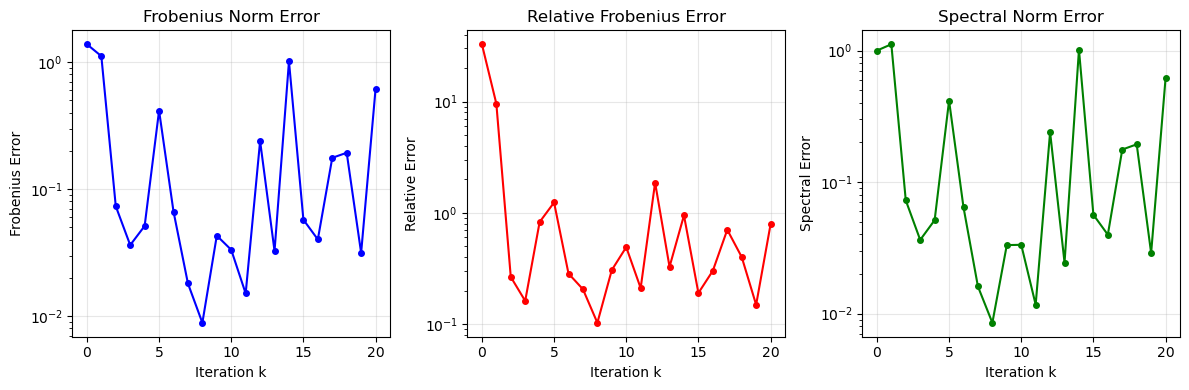

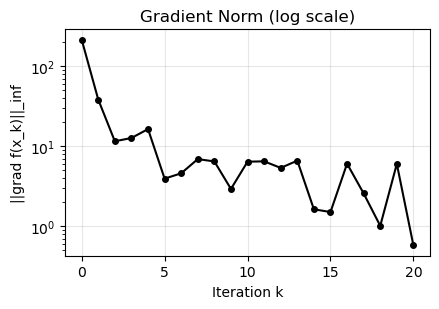


Detailed Comparison at Selected Iterations:
--------------------------------------------------

Iteration 0:
  H(k):
    [[1. 0.]
 [0. 1.]]
  G(x_k)^{-1}:
    [[ 0.00561798 -0.01348315]
 [-0.01348315  0.03735957]]
  H(k) - G(x_k)^{-1}:
    [[0.99438202 0.01348315]
 [0.01348315 0.96264043]]

Iteration 5:
  H(k):
    [[ 0.03913533 -0.03854108]
 [-0.03854108  0.04291106]]
  G(x_k)^{-1}:
    [[-0.17012168  0.16930189]
 [ 0.16930189 -0.16348606]]
  H(k) - G(x_k)^{-1}:
    [[ 0.20925701 -0.20784297]
 [-0.20784297  0.20639712]]
  Secant condition error (H(k) y(k-1) - s(k-1)): 3.51e-16

Iteration 10:
  H(k):
    [[ 0.09842234 -0.01263975]
 [-0.01263975  0.00728262]]
  G(x_k)^{-1}:
    [[ 0.0673917  -0.00419913]
 [-0.00419913  0.00526165]]
  H(k) - G(x_k)^{-1}:
    [[ 0.03103064 -0.00844062]
 [-0.00844062  0.00202097]]
  Secant condition error (H(k) y(k-1) - s(k-1)): 1.39e-17

Iteration 20:
  H(k):
    [[0.06793555 0.08096361]
 [0.08096361 0.10113857]]
  G(x_k)^{-1}:
    [[0.31725405 0.3829295

In [ ]:
# Task 12: BFGS Hessian Approximation Quality Analysis
import numpy as np
import matplotlib.pyplot as plt
from chebyquad_problem import chebyquad, gradchebyquad

# BFGS-with-tracking: minimal edits, fixes for FD Hessian and evidence plots
class BFGSTracking(BFGS):
    def __init__(self, problem, tol=1e-6, max_iter=100):
        super().__init__(problem, tol, max_iter)
        self.hessian_history = []          # H(k)
        self.true_hessian_history = []     # G(x_k)^{-1}
        self.approximation_errors = []     # norms of H(k)G^{-1}(x_k) - I

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        g = self.problem.gradient(x)
        n = len(x)

        H = np.eye(n)  # initial inverse-Hessian approximation

        self.history = [x.copy()]
        self.hessian_history = [H.copy()]

        H_true = self.compute_true_inverse_hessian(x)
        self.true_hessian_history = [H_true]
        self.approximation_errors = [self.compute_approximation_error(H, H_true)]

        for k in range(self.max_iter):
            if np.linalg.norm(g, np.inf) < self.tol:
                break

            # search direction and line search (assumes you have this in your codebase)
            s = -H.dot(g)
            alpha = line_search_wolfe(self.problem, x, s, g)
            x_new = x + alpha * s
            g_new = self.problem.gradient(x_new)

            y = g_new - g
            s_vec = x_new - x

            # BFGS update (your BFGS.update implementation)
            H = self.update(H, s_vec, y, g, g_new)

            # track at the NEW iterate k+1
            H_true = self.compute_true_inverse_hessian(x_new)
            self.history.append(x_new.copy())
            self.hessian_history.append(H.copy())
            self.true_hessian_history.append(H_true)
            self.approximation_errors.append(self.compute_approximation_error(H, H_true))

            x, g = x_new, g_new

        return x

    def compute_true_inverse_hessian(self, x):
        """Finite-difference Hessian with scaling and symmetrization; invert safely."""
        n = len(x)
        G = np.zeros((n, n))
        fx = self.problem.evaluate(x)

        # scaled central-difference step to reduce noise
        h = 1e-5 * (1.0 + np.linalg.norm(x))
        e = np.eye(n)

        for i in range(n):
            for j in range(i, n):
                if i == j:
                    G[i, i] = (self.problem.evaluate(x + h * e[i])
                               - 2.0 * fx
                               + self.problem.evaluate(x - h * e[i])) / (h * h)
                else:
                    fpp = self.problem.evaluate(x + h * e[i] + h * e[j])
                    fpm = self.problem.evaluate(x + h * e[i] - h * e[j])
                    fmp = self.problem.evaluate(x - h * e[i] + h * e[j])
                    fmm = self.problem.evaluate(x - h * e[i] - h * e[j])
                    val = (fpp - fpm - fmp + fmm) / (4.0 * h * h)
                    G[i, j] = G[j, i] = val

        # enforce symmetry
        G = 0.5 * (G + G.T)

        # invert; if ill-conditioned, fall back to pseudo-inverse
        try:
            # small Tikhonov regularization if needed
            return np.linalg.inv(G)
        except np.linalg.LinAlgError:
            return np.linalg.pinv(G)

    def compute_approximation_error(self, H_approx, H_true_inv):
        """Errors for H(k) versus true inverse Hessian."""
        E = H_approx - H_true_inv
        frob = np.linalg.norm(E, "fro")
        rel = frob / (np.linalg.norm(H_true_inv, "fro") + 1e-18)
        spec = np.linalg.norm(E, 2)
        return {"frobenius": frob, "relative": rel, "spectral": spec}


# Rosenbrock test (compact)
def rosenbrock_f(x):
    return 100.0 * (x[1] - x[0] ** 2) ** 2 + (1.0 - x[0]) ** 2

def rosenbrock_grad(x):
    return np.array([
        -400.0 * x[0] * (x[1] - x[0] ** 2) - 2.0 * (1.0 - x[0]),
         200.0 * (x[1] - x[0] ** 2)
    ])


print("Task 12: BFGS Hessian Approximation Quality Analysis")
print("=" * 60)

problem = OptimizationProblem(rosenbrock_f, rosenbrock_grad)
x0 = np.array([-1.2, 1.0])

tracker = BFGSTracking(problem, tol=1e-8, max_iter=20)
x_star = tracker.solve(x0)

print(f"Optimization iterations: {len(tracker.history) - 1}")
print(f"Final point: {x_star}")
print(f"Final f(x): {problem.evaluate(x_star):.2e}")

# Print first few and last few error rows
print("\nHessian Approximation Errors:")
print("-" * 50)
iters = len(tracker.approximation_errors)
print(f"{'k':>3s} {'Frob':>12s} {'RelFrob':>12s} {'Spec':>12s}")
print("-" * 50)
show_head = min(10, iters)
for k in range(show_head):
    e = tracker.approximation_errors[k]
    print(f"{k:3d} {e['frobenius']:12.2e} {e['relative']:12.2e} {e['spectral']:12.2e}")
if iters > show_head:
    print("...")
    for k in range(max(0, iters - 3), iters):
        e = tracker.approximation_errors[k]
        print(f"{k:3d} {e['frobenius']:12.2e} {e['relative']:12.2e} {e['spectral']:12.2e}")

# Plots: error norms and gradient norm (superlinear evidence)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
frob = [e["frobenius"] for e in tracker.approximation_errors]
plt.semilogy(range(len(frob)), frob, "b-o", markersize=4)
plt.xlabel("Iteration k")
plt.ylabel("Frobenius Error")
plt.title("Frobenius Norm Error")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
rel = [e["relative"] for e in tracker.approximation_errors]
plt.semilogy(range(len(rel)), rel, "r-o", markersize=4)
plt.xlabel("Iteration k")
plt.ylabel("Relative Error")
plt.title("Relative Frobenius Error")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
spec = [e["spectral"] for e in tracker.approximation_errors]
plt.semilogy(range(len(spec)), spec, "g-o", markersize=4)
plt.xlabel("Iteration k")
plt.ylabel("Spectral Error")
plt.title("Spectral Norm Error")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gradient-norm curve (simple superlinear evidence near solution)
grad_norms = [np.linalg.norm(rosenbrock_grad(xk), np.inf) for xk in tracker.history]
plt.figure(figsize=(4.5, 3.2))
plt.semilogy(range(len(grad_norms)), grad_norms, "k-o", markersize=4)
plt.xlabel("Iteration k")
plt.ylabel("||grad f(x_k)||_inf")
plt.title("Gradient Norm (log scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Detailed snapshots at selected iterations
print("\nDetailed Comparison at Selected Iterations:")
print("-" * 50)
snapshots = [0, min(5, iters - 1), min(10, iters - 1), iters - 1]
for k in snapshots:
    Hk = tracker.hessian_history[k]
    Htrue = tracker.true_hessian_history[k]
    print(f"\nIteration {k}:")
    print("  H(k):")
    print(f"    {Hk}")
    print("  G(x_k)^{-1}:")
    print(f"    {Htrue}")
    print("  H(k) - G(x_k)^{-1}:")
    print(f"    {Hk - Htrue}")

    if k > 0:
        # Secant condition uses H(k) with y(k-1) = g_k - g_{k-1}, s(k-1) = x_k - x_{k-1}
        s_prev = tracker.history[k] - tracker.history[k - 1]
        g_prev = rosenbrock_grad(tracker.history[k - 1])
        g_curr = rosenbrock_grad(tracker.history[k])
        y_prev = g_curr - g_prev
        secant_err = np.linalg.norm(Hk @ y_prev - s_prev)
        print(f"  Secant condition error (H(k) y(k-1) - s(k-1)): {secant_err:.2e}")

